In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import time 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from functools import partial

def initialization():
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

1. 搭建模型

In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten
from keras.models import Model
from keras.regularizers import l2
from keras.layers.merge import concatenate

In [3]:
from functools import partial

default_Conv2D = partial(keras.layers.Conv2D,
                         activation=keras.activations.relu,
                         padding='SAME',
                         kernel_regularizer=l2(0.01))

default_MaxPool = partial(keras.layers.MaxPool2D,
                          pool_size=3,
                          strides=2,
                          padding='SAME')

In [4]:
# 定义Inception块
def inception_model(input, filters_1x1, filters_3x3_reduce, filters_3x3,
                    filters_5x5_reduce, filters_5x5, filters_pool_proj):
    conv_1x1 = default_Conv2D(filters=filters_1x1, kernel_size=1)(input)

    conv_3x3_reduce = default_Conv2D(filters=filters_3x3_reduce, kernel_size=1)(input)
    conv_3x3 = default_Conv2D(filters=filters_3x3, kernel_size=3)(conv_3x3_reduce)

    conv_5x5_reduce = default_Conv2D(filters=filters_5x5_reduce, kernel_size=1)(input)
    conv_5x5 = default_Conv2D(filters=filters_5x5, kernel_size=5)(conv_5x5_reduce)

    maxpool = MaxPooling2D(pool_size=3, strides=1, padding='same')(input)
    maxpool_proj = default_Conv2D(filters=filters_pool_proj,
                                  kernel_size=1,
                                  strides=1)(maxpool)

    inception_output = concatenate(
        [conv_1x1, conv_3x3, conv_5x5, maxpool_proj],
        axis=3)  # use tf as backend

    return inception_output

In [5]:
input = Input(shape=(224, 224, 3))

conv1_7x7_s2 = default_Conv2D(filters=64, kernel_size=7, strides=2)(input)
maxpool1_3x3_s2 = default_MaxPool()(conv1_7x7_s2)
conv2_3x3_reduce = default_Conv2D(filters=64, kernel_size=1)(maxpool1_3x3_s2)
conv2_3x3 = default_Conv2D(filters=192, kernel_size=3)(conv2_3x3_reduce)
maxpool2_3x3_s2 = default_MaxPool()(conv2_3x3)

inception_3a = inception_model(input=maxpool2_3x3_s2, 
                               filters_1x1=64, 
                               filters_3x3_reduce=96, 
                               filters_3x3=128, 
                               filters_5x5_reduce=16, 
                               filters_5x5=32, 
                               filters_pool_proj=32)

inception_3b = inception_model(input=inception_3a, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64)

maxpool3_3x3_s2 = default_MaxPool()(inception_3b)

inception_4a = inception_model(input=maxpool3_3x3_s2, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64)

inception_4b = inception_model(input=inception_4a, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)

inception_4c = inception_model(input=inception_4b, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool_proj=64)

inception_4d = inception_model(input=inception_4c, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool_proj=64)

inception_4e = inception_model(input=inception_4d, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128)

maxpool4_3x3_s2 = default_MaxPool()(inception_4e)

inception_5a = inception_model(input=maxpool4_3x3_s2, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool_proj=128)

inception_5b = inception_model(input=inception_5a, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool_proj=128)

averagepool1_7x7_s1 = AveragePooling2D(pool_size=7, strides=7, padding='same')(inception_5b)

drop1 = Dropout(rate=0.4)(averagepool1_7x7_s1)
linear = Flatten()(drop1)
output = Dense(units=10, activation="softmax", kernel_regularizer=l2(0.01))(linear)

model = Model(inputs=input, outputs=output)

2022-03-11 12:56:19.979515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 12:56:20.072793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 12:56:20.073500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-11 12:56:20.074569: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### 1

2. 加载,预处理数据集

- 加载TensorFlow 数据集项目,使用方法详见`第13章`

In [6]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("Cifar10", as_supervised=True, with_info=True)
# with_info:获取有关数据集的信息

2022-03-11 12:56:23.908457: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [7]:
class_names = info.features["label"].names
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

`Cifar10`数据集详细信息:https://tensorflow.google.cn/datasets/catalog/cifar10

In [8]:
train_set_raw = tfds.load("Cifar10", as_supervised=True)['train']

In [9]:
test_set_raw, valid_set_raw = tfds.load("Cifar10",
                                        split=["test[:60%]", "test[60%:]"],
                                        as_supervised=True)

2022-03-11 12:57:31.978596: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-11 12:57:32.153873: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


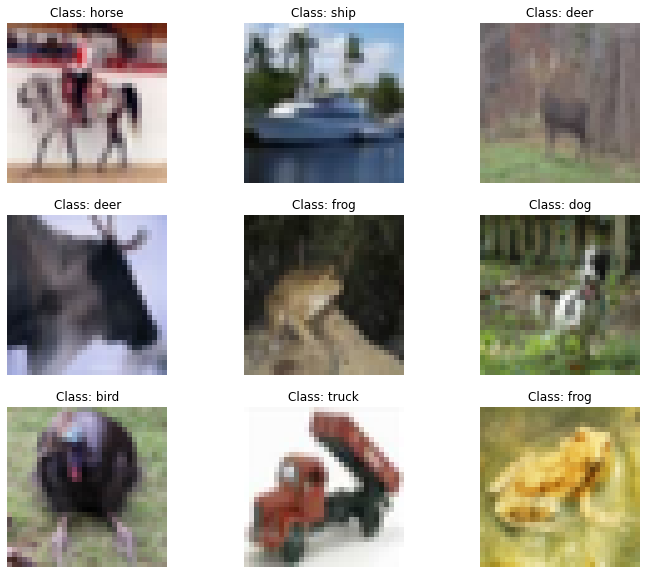

In [10]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
plt.show()

In [11]:
from keras.utils import np_utils


# 预处理
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    label = tf.cast(label, dtype=tf.int32)  # 数据类型转换
    label = tf.squeeze(label)  # tf.squeeze():用于从张量形状中移除大小为1的维度
    label = tf.one_hot(label, depth=10)
    return resized_image, label


batch_size = 128
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [12]:
import os
import time

In [13]:
root_logdir = os.path.join(os.curdir, "./Logs/my_GoogLeNet_logs")
root_logdir

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_dir = get_run_logdir()
run_dir

tensorboard_cb = keras.callbacks.TensorBoard(run_dir)

2022-03-11 12:57:32.694984: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-11 12:57:32.695035: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-11 12:57:32.696152: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-03-11 12:57:32.869122: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-11 12:57:32.869324: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


3. 训练评估模型

In [14]:
# 编译模型
optimizer = keras.optimizers.SGD(learning_rate=1e-3,
                                 momentum=0.9,
                                 nesterov=True,
                                 decay=0.001)
# 训练模型
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.4 * test_size / batch_size),
                    epochs=70,
                    callbacks=[tensorboard_cb])

Epoch 1/70


2022-03-11 12:57:38.122428: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/390 [..............................] - ETA: 1:25:24 - loss: 85.1026 - accuracy: 0.0469

2022-03-11 12:57:46.447804: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-11 12:57:46.447853: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/390 [..............................] - ETA: 3:56 - loss: 84.8974 - accuracy: 0.1016   

2022-03-11 12:57:46.961509: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-11 12:57:46.963592: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-03-11 12:57:47.122411: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1914 callback api events and 1911 activity events. 
2022-03-11 12:57:47.183708: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-11 12:57:47.269097: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ././Logs/my_GoogLeNet_logs/run_2022_03_11-12_57_32/train/plugins/profile/2022_03_11_12_57_47

2022-03-11 12:57:47.319661: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ././Logs/my_GoogLeNet_logs/run_2022_03_11-12_57_32/train/plugins/profile/2022_03_11_12_57_47/192896360c8f.trace.json.gz
2022-03-11 12:57:47.397418: 

390/390 [==============================] - 106s 237ms/step - loss: 79.0911 - accuracy: 0.2304 - val_loss: 74.0914 - val_accuracy: 0.3246
Epoch 2/70
390/390 [==============================] - 88s 227ms/step - loss: 70.4653 - accuracy: 0.3532 - val_loss: 67.1364 - val_accuracy: 0.4050
Epoch 3/70
390/390 [==============================] - 88s 226ms/step - loss: 64.4996 - accuracy: 0.4087 - val_loss: 62.0821 - val_accuracy: 0.4317
Epoch 4/70
390/390 [==============================] - 88s 227ms/step - loss: 60.0262 - accuracy: 0.4475 - val_loss: 58.1655 - val_accuracy: 0.4647
Epoch 5/70
390/390 [==============================] - 88s 227ms/step - loss: 56.5007 - accuracy: 0.4761 - val_loss: 54.9123 - val_accuracy: 0.5126
Epoch 6/70
390/390 [==============================] - 88s 227ms/step - loss: 53.6202 - accuracy: 0.4974 - val_loss: 52.3579 - val_accuracy: 0.5048
Epoch 7/70
390/390 [==============================] - 88s 227ms/step - loss: 51.1991 - accuracy: 0.5182 - val_loss: 50.0735 - va

In [15]:
model.save('./models/GoogLeNet_model.h5')

In [16]:
model = keras.models.load_model("./models/GoogLeNet_model.h5")
model.evaluate(test_set)

47/47 [==============================] - 7s 135ms/step - loss: 22.9746 - accuracy: 0.6985


[22.97458267211914, 0.6984999775886536]